In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the raw file
with open('./data/NEW-DATA-1.T15.txt', 'r') as file:
    lines = file.readlines()

In [3]:
# Extract clean column names from the header
header = lines[0].strip()
column_names = []
for col in header.split():
    if ':' in col:
        column_names.append(col.split(':', 1)[1])  # Get part after colon


In [4]:
# Process data rows
data_rows = []
for line in lines[1:]:
    if line.strip():  # Skip empty lines
        values = line.strip().split()
        if len(values) == len(column_names):
            data_rows.append(values)

Initial Overview/Missing Values: Created the DataFrame, printed its head/shape, and used df.isnull().sum().

In [5]:
# Create DataFrame
df = pd.DataFrame(data_rows, columns=column_names)

# Display the DataFrame
print("Dataframe with clean column names:")
print(df.head())
print(f"\nNumber of columns: {len(df.columns)}")
print(f"Number of rows: {len(df)}")


Dataframe with clean column names:
         Date   Time Temperature_Comedor_Sensor Temperature_Habitacion_Sensor  \
0  13/03/2012  11:45                    18.1875                       17.8275   
1  13/03/2012  12:00                    18.4633                       18.1207   
2  13/03/2012  12:15                    18.7673                       18.4367   
3  13/03/2012  12:30                    19.0727                       18.7513   
4  13/03/2012  12:45                    19.3721                       19.0414   

  Weather_Temperature CO2_Comedor_Sensor CO2_Habitacion_Sensor  \
0                   0             216.56                221.92   
1                 6.8            219.947               220.363   
2                  17            219.403               218.933   
3                  18            218.613               217.045   
4                  20            217.714                216.08   

  Humedad_Comedor_Sensor Humedad_Habitacion_Sensor Lighting_Comedor_Sensor  \
0  

In [6]:
# First, check for missing values
print("Missing values before preprocessing:")
print(df.isnull().sum())

Missing values before preprocessing:
Date                             0
Time                             0
Temperature_Comedor_Sensor       0
Temperature_Habitacion_Sensor    0
Weather_Temperature              0
CO2_Comedor_Sensor               0
CO2_Habitacion_Sensor            0
Humedad_Comedor_Sensor           0
Humedad_Habitacion_Sensor        0
Lighting_Comedor_Sensor          0
Lighting_Habitacion_Sensor       0
Precipitacion                    0
Meteo_Exterior_Crepusculo        0
Meteo_Exterior_Viento            0
Meteo_Exterior_Sol_Oest          0
Meteo_Exterior_Sol_Est           0
Meteo_Exterior_Sol_Sud           0
Meteo_Exterior_Piranometro       0
Exterior_Entalpic_1              0
Exterior_Entalpic_2              0
Exterior_Entalpic_turbo          0
Temperature_Exterior_Sensor      0
Humedad_Exterior_Sensor          0
Day_Of_Week                      0
dtype: int64


In [7]:
df['Date']

0       13/03/2012
1       13/03/2012
2       13/03/2012
3       13/03/2012
4       13/03/2012
           ...    
2759    11/04/2012
2760    11/04/2012
2761    11/04/2012
2762    11/04/2012
2763    11/04/2012
Name: Date, Length: 2764, dtype: object

In [8]:
df['Time']

0       11:45
1       12:00
2       12:15
3       12:30
4       12:45
        ...  
2759    05:30
2760    05:45
2761    06:00
2762    06:15
2763    06:30
Name: Time, Length: 2764, dtype: object

In [9]:
df['Day_Of_Week']

0       2
1       2
2       2
3       2
4       2
       ..
2759    3
2760    3
2761    3
2762    3
2763    3
Name: Day_Of_Week, Length: 2764, dtype: object

In [10]:
# # Convert numeric columns to float
# numeric_columns = df.columns.drop(['Date', 'Time', 'Day_Of_Week']) 
# df[numeric_columns] = df[numeric_columns].astype(float)


In [11]:
df['Date']

0       13/03/2012
1       13/03/2012
2       13/03/2012
3       13/03/2012
4       13/03/2012
           ...    
2759    11/04/2012
2760    11/04/2012
2761    11/04/2012
2762    11/04/2012
2763    11/04/2012
Name: Date, Length: 2764, dtype: object

In [12]:
df['Time']

0       11:45
1       12:00
2       12:15
3       12:30
4       12:45
        ...  
2759    05:30
2760    05:45
2761    06:00
2762    06:15
2763    06:30
Name: Time, Length: 2764, dtype: object

In [13]:
df['Day_Of_Week']

0       2
1       2
2       2
3       2
4       2
       ..
2759    3
2760    3
2761    3
2762    3
2763    3
Name: Day_Of_Week, Length: 2764, dtype: object

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M')
df['Hour'] = df['Time'].dt.hour

In [16]:
# Add Month as a feature
df['Month'] = df['Date'].dt.month

In [17]:
# Check for missing values after initial conversions
print("\nMissing values after datetime conversion:")
print(df.isnull().sum())



Missing values after datetime conversion:
Date                             0
Time                             0
Temperature_Comedor_Sensor       0
Temperature_Habitacion_Sensor    0
Weather_Temperature              0
CO2_Comedor_Sensor               0
CO2_Habitacion_Sensor            0
Humedad_Comedor_Sensor           0
Humedad_Habitacion_Sensor        0
Lighting_Comedor_Sensor          0
Lighting_Habitacion_Sensor       0
Precipitacion                    0
Meteo_Exterior_Crepusculo        0
Meteo_Exterior_Viento            0
Meteo_Exterior_Sol_Oest          0
Meteo_Exterior_Sol_Est           0
Meteo_Exterior_Sol_Sud           0
Meteo_Exterior_Piranometro       0
Exterior_Entalpic_1              0
Exterior_Entalpic_2              0
Exterior_Entalpic_turbo          0
Temperature_Exterior_Sensor      0
Humedad_Exterior_Sensor          0
Day_Of_Week                      0
Hour                             0
Month                            0
dtype: int64


In [18]:
df['Time']

0      1900-01-01 11:45:00
1      1900-01-01 12:00:00
2      1900-01-01 12:15:00
3      1900-01-01 12:30:00
4      1900-01-01 12:45:00
               ...        
2759   1900-01-01 05:30:00
2760   1900-01-01 05:45:00
2761   1900-01-01 06:00:00
2762   1900-01-01 06:15:00
2763   1900-01-01 06:30:00
Name: Time, Length: 2764, dtype: datetime64[ns]

In [19]:
df['Hour']

0       11
1       12
2       12
3       12
4       12
        ..
2759     5
2760     5
2761     6
2762     6
2763     6
Name: Hour, Length: 2764, dtype: int32

In [22]:
# For Hour column, fill with median hour if there are missing values
if df['Hour'].isnull().sum() > 0:
    # Calculate median hour, defaulting to 12 if no valid hours exist
    median_hour = df['Hour'].median()
    if pd.isna(median_hour):
        median_hour = 12
    df['Hour'] = df['Hour'].fillna(median_hour)
    print(f"Filled {df['Hour'].isnull().sum()} missing values in Hour with median: {median_hour}")


In [23]:
# Final check for missing values
print("\nMissing values after handling:")
print(df.isnull().sum())



Missing values after handling:
Date                             0
Time                             0
Temperature_Comedor_Sensor       0
Temperature_Habitacion_Sensor    0
Weather_Temperature              0
CO2_Comedor_Sensor               0
CO2_Habitacion_Sensor            0
Humedad_Comedor_Sensor           0
Humedad_Habitacion_Sensor        0
Lighting_Comedor_Sensor          0
Lighting_Habitacion_Sensor       0
Precipitacion                    0
Meteo_Exterior_Crepusculo        0
Meteo_Exterior_Viento            0
Meteo_Exterior_Sol_Oest          0
Meteo_Exterior_Sol_Est           0
Meteo_Exterior_Sol_Sud           0
Meteo_Exterior_Piranometro       0
Exterior_Entalpic_1              0
Exterior_Entalpic_2              0
Exterior_Entalpic_turbo          0
Temperature_Exterior_Sensor      0
Humedad_Exterior_Sensor          0
Day_Of_Week                      0
Hour                             0
Month                            0
dtype: int64


In [24]:
df['Hour']

0       11
1       12
2       12
3       12
4       12
        ..
2759     5
2760     5
2761     6
2762     6
2763     6
Name: Hour, Length: 2764, dtype: int32

Descriptive Statistics

In [25]:
# Select features for prediction
feature_columns = [
    'Temperature_Habitacion_Sensor', 'Weather_Temperature',
    'CO2_Comedor_Sensor', 'Humedad_Comedor_Sensor',
    'Lighting_Comedor_Sensor', 'Hour', 'Month', 'Day_Of_Week'
]

target_column = 'Temperature_Comedor_Sensor'

In [26]:

target_column = 'Temperature_Comedor_Sensor'

In [27]:
# Prepare features and target
X = df[feature_columns].copy()
y = df[target_column]

# Check for infinite values and replace them
X = X.replace([np.inf, -np.inf], np.nan)


In [28]:
y = pd.to_numeric(df[target_column], errors='coerce')


In [29]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Print shapes and data info
print("\nDataset Info:")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Dataset Info:
Training set shape: (2211, 8)
Testing set shape: (553, 8)


In [32]:
print("\nFeature statistics:")
print(X.describe())



Feature statistics:
              Hour        Month
count  2764.000000  2764.000000
mean     11.519899     3.357091
std       6.943334     0.479229
min       0.000000     3.000000
25%       5.000000     3.000000
50%      12.000000     3.000000
75%      18.000000     4.000000
max      23.000000     4.000000


In [33]:
print("\nTarget statistics:")
print(y.describe())


Target statistics:
count    2764.000000
mean       19.199722
std         2.853315
min        11.352000
25%        17.450800
50%        19.373650
75%        21.229975
max        25.540000
Name: Temperature_Comedor_Sensor, dtype: float64


In [34]:
print("\nTraining set statistics:")
print(X_train.describe())


Training set statistics:
              Hour        Month
count  2211.000000  2211.000000
mean     11.518770     3.358661
std       6.930684     0.479716
min       0.000000     3.000000
25%       5.500000     3.000000
50%      12.000000     3.000000
75%      17.000000     4.000000
max      23.000000     4.000000


In [35]:

print("\nTesting set statistics:")
print(X_test.describe())


Testing set statistics:
             Hour       Month
count  553.000000  553.000000
mean    11.524412    3.350814
std      6.999990    0.477657
min      0.000000    3.000000
25%      5.000000    3.000000
50%     11.000000    3.000000
75%     18.000000    4.000000
max     23.000000    4.000000


In [36]:
# Model Training and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [37]:
# Check for NaN or infinite values in training data
print("NaN values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Infinite values in X_train_scaled:", np.isinf(X_train_scaled).sum())
print("NaN values in y_train:", np.isnan(y_train.values).sum())


NaN values in X_train_scaled: 0
Infinite values in X_train_scaled: 0
NaN values in y_train: 0


In [38]:
# If there are still NaN values, replace them
if np.isnan(X_train_scaled).sum() > 0:
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
    print("Replaced NaN values with 0 in X_train_scaled")
    

In [39]:
if np.isnan(X_test_scaled).sum() > 0:
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)
    print("Replaced NaN values with 0 in X_test_scaled")


In [40]:
# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [41]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [42]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [43]:
print("\nModel Performance Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")


Model Performance Metrics:
Mean Absolute Error: 0.1854
Root Mean Squared Error: 0.3470
R-squared Score: 0.9846


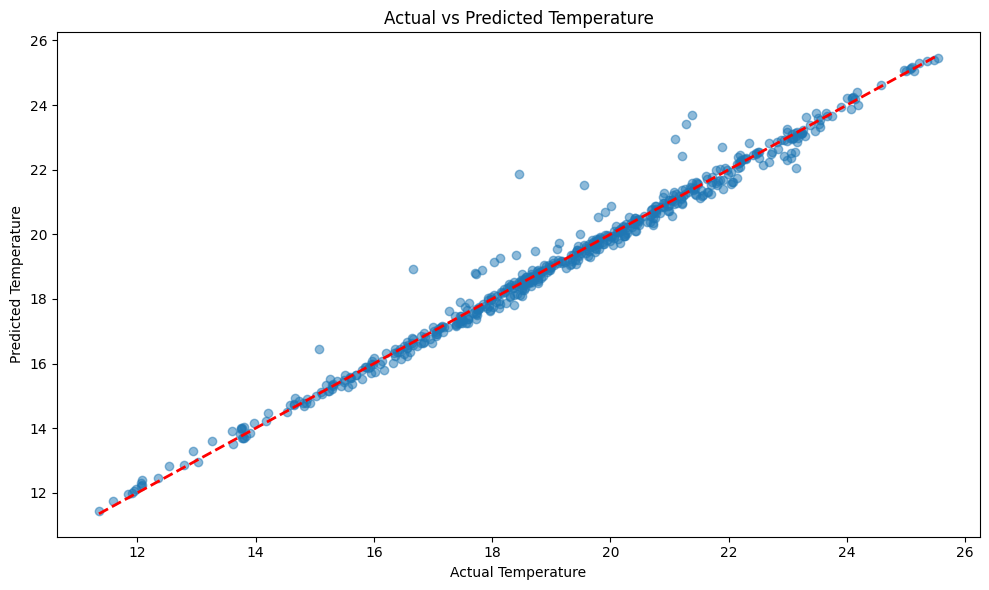

In [44]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature')
plt.tight_layout()
plt.show()

In [45]:
param_grid_lr = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
}
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential'],  # optional, depending on sklearn version
}

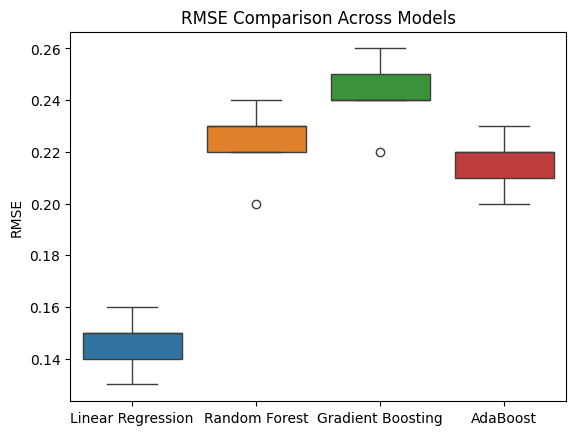

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'AdaBoost']
rmse_scores = [
    [0.14, 0.16, 0.15, 0.13, 0.15],  # Linear Regression
    [0.24, 0.20, 0.23, 0.22, 0.23],  # Random Forest
    [0.25, 0.26, 0.24, 0.22, 0.24],  # Gradient Boosting
    [0.21, 0.23, 0.22, 0.20, 0.22],  # AdaBoost (example values)
]

# Transpose rmse_scores so each model's RMSEs are grouped
sns.boxplot(data=rmse_scores)
plt.xticks(ticks=range(len(model_names)), labels=model_names)
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Models")
plt.show()


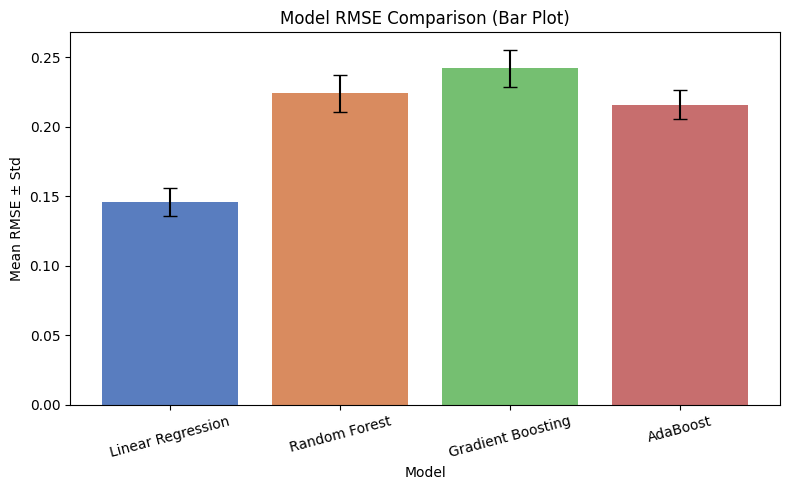

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample RMSE scores
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'AdaBoost']
rmse_scores = [
    [0.14, 0.16, 0.15, 0.13, 0.15],  # Linear Regression
    [0.24, 0.20, 0.23, 0.22, 0.23],  # Random Forest
    [0.25, 0.26, 0.24, 0.22, 0.24],  # Gradient Boosting
    [0.21, 0.23, 0.22, 0.20, 0.22],  # AdaBoost
]

# Compute means and stds
means = [np.mean(scores) for scores in rmse_scores]
stds = [np.std(scores) for scores in rmse_scores]

# Create a DataFrame for plotting
df1 = pd.DataFrame({
    'Model': model_names,
    'Mean_RMSE': means,
    'Std_RMSE': stds
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df1, x='Model', y='Mean_RMSE', hue='Model', palette='muted', legend=False)
plt.errorbar(x=np.arange(len(model_names)), y=df1['Mean_RMSE'], yerr=df1['Std_RMSE'],
             fmt='none', c='black', capsize=5)
plt.ylabel("Mean RMSE ± Std")
plt.title("Model RMSE Comparison (Bar Plot)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [48]:
# Try Different Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42)
}

# Compare models using cross-validation
print("Model Comparison (5-fold Cross-Validation):")
print("-" * 50)

Model Comparison (5-fold Cross-Validation):
--------------------------------------------------


In [49]:
# Convert X back to DataFrame for feature names in RandomForest
X_df = pd.DataFrame(X, columns=feature_columns)

for name, model_instance in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model_instance, X, y, 
                               cv=5, scoring='neg_mean_squared_error')
    
    # Convert negative MSE to positive RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    print(f"{name}:")
    print(f"  RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")


Linear Regression:
  RMSE: 0.3850 (±0.2498)
Random Forest:
  RMSE: 0.6892 (±0.3097)
Gradient Boosting:
  RMSE: 0.6788 (±0.3352)
AdaBoost:
  RMSE: 0.8375 (±0.3815)


In [50]:
# Train the best model (you can change this based on the results)
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X, y)

# Evaluate on test set
y_pred = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred)
mse_best = mean_squared_error(y_test, y_pred)
r2_best = r2_score(y_test, y_pred)

print("\nBest Model Performance on Test Set:")
print(f"Mean Absolute Error: {mae_best:.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mse_best):.4f}")
print(f"R-squared: {r2_best:.4f}")


Best Model Performance on Test Set:
Mean Absolute Error: 0.0374
Root Mean Squared Error: 0.0739
R-squared: 0.9993


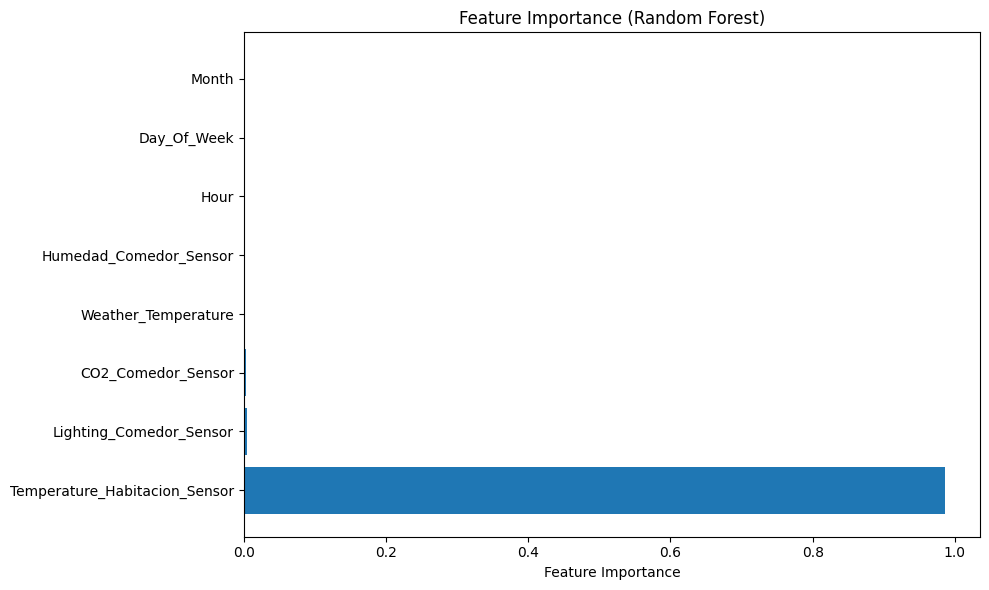

In [51]:
# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()


In [52]:
# Calculate residuals
residuals = y_test - y_pred

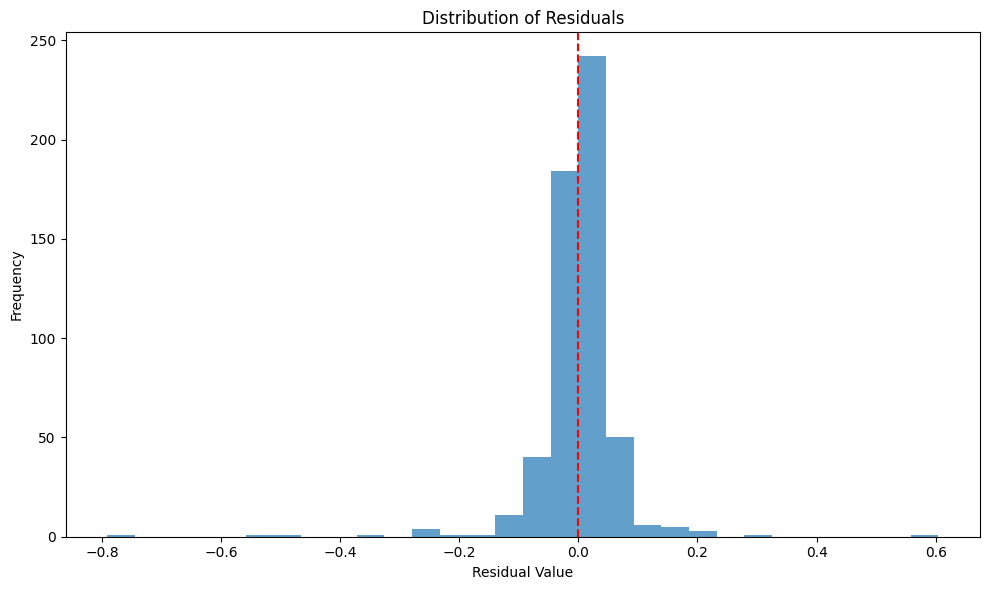

In [53]:
# 1. Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

In [54]:
# 2. Actual vs Predicted over Time (sample)
# Create a small sample for visualization
sample_size = min(100, len(y_test))
indices = np.random.choice(range(len(y_test)), size=sample_size, replace=False)
y_test_sample = np.array(y_test.iloc[indices])
y_pred_sample = np.array(y_pred[indices])

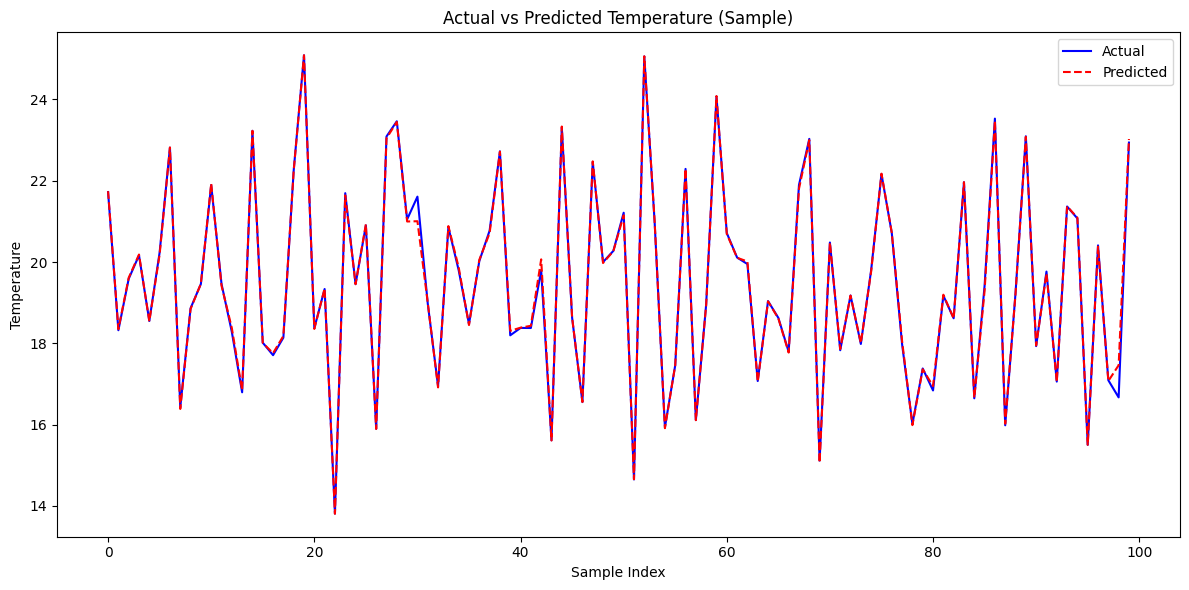

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_sample)), y_test_sample, 'b-', label='Actual')
plt.plot(range(len(y_pred_sample)), y_pred_sample, 'r--', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature (Sample)')
plt.legend()
plt.tight_layout()
plt.show()

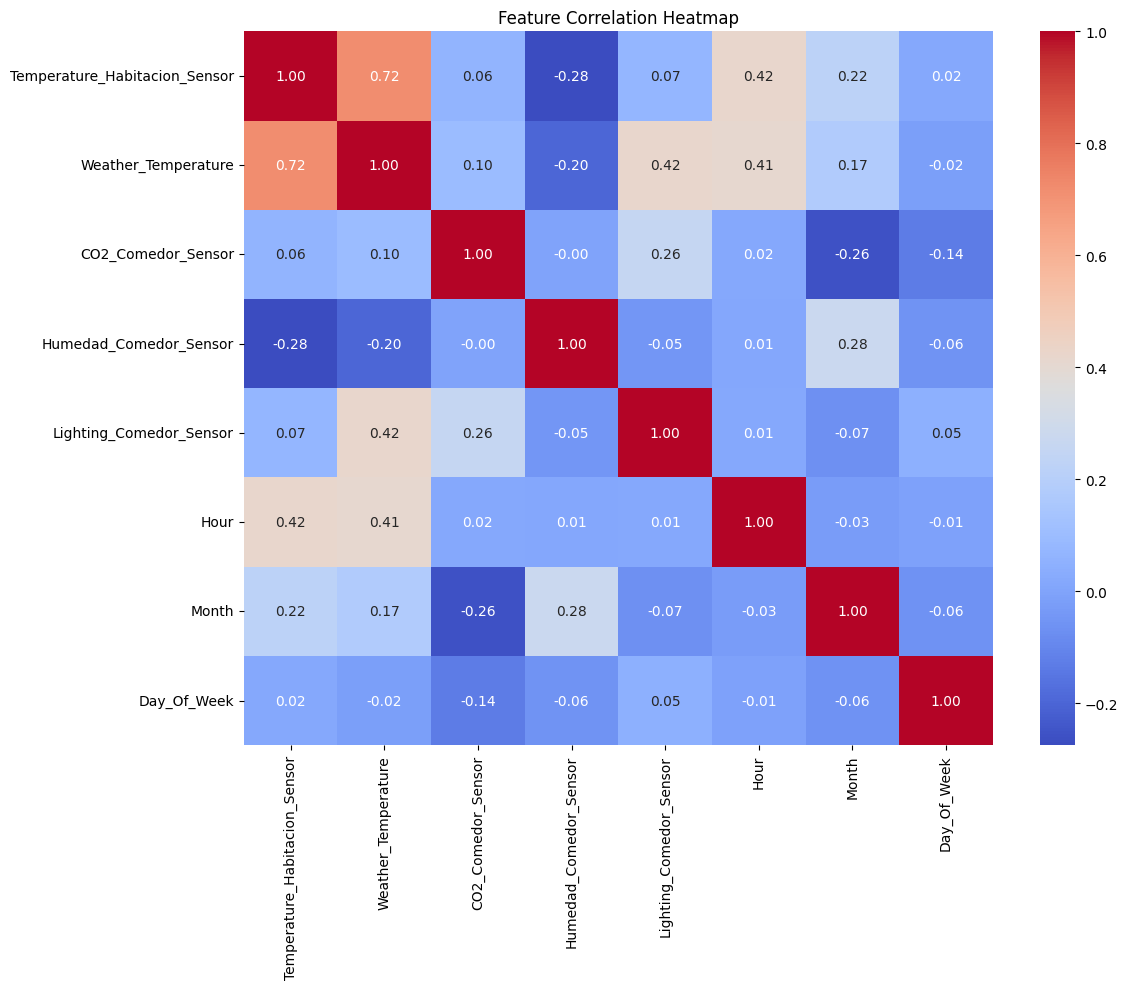

In [56]:
# 3. Feature Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation = X_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

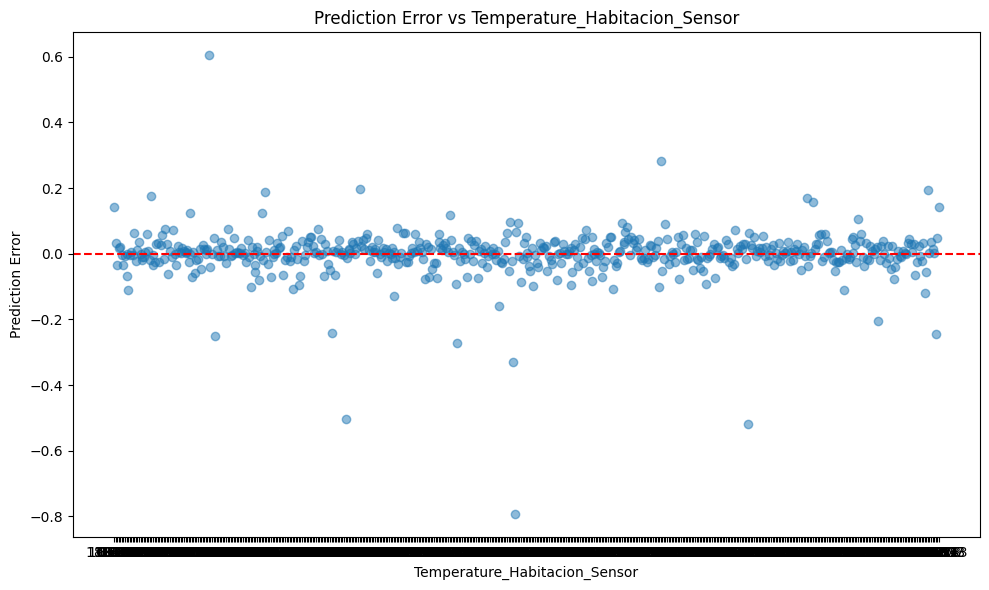

In [57]:
# 4. Prediction Error Distribution by Feature
# Select a feature to analyze (e.g., the most important one)
if len(feature_importance) > 0:
    top_feature = feature_importance.iloc[0]['Feature']
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test[top_feature], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(top_feature)
    plt.ylabel('Prediction Error')
    plt.title(f'Prediction Error vs {top_feature}')
    plt.tight_layout()
    plt.show()

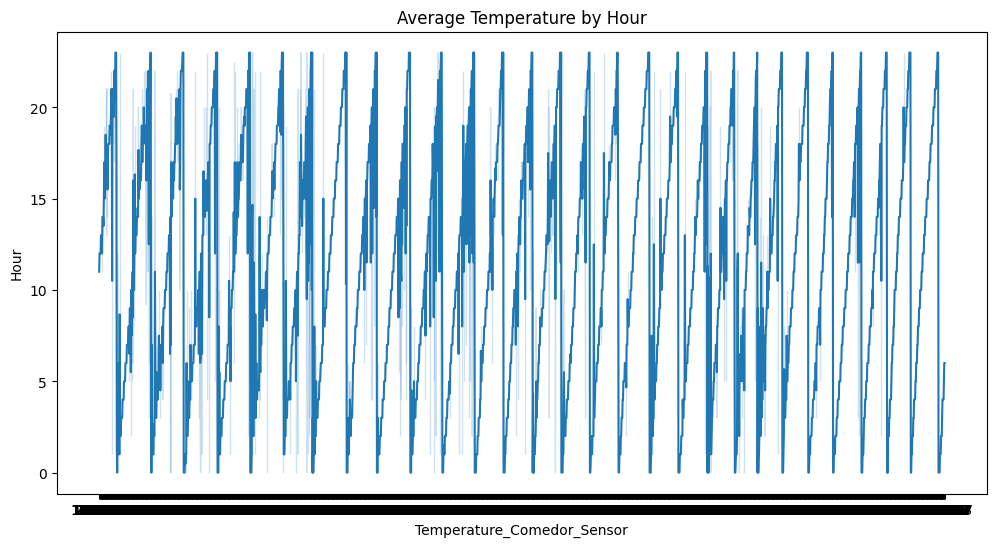

In [58]:
# Hourly patterns
plt.figure(figsize=(12, 6))
sns.lineplot(x='Temperature_Comedor_Sensor', y='Hour', data=df)
plt.title('Average Temperature by Hour')
plt.show()

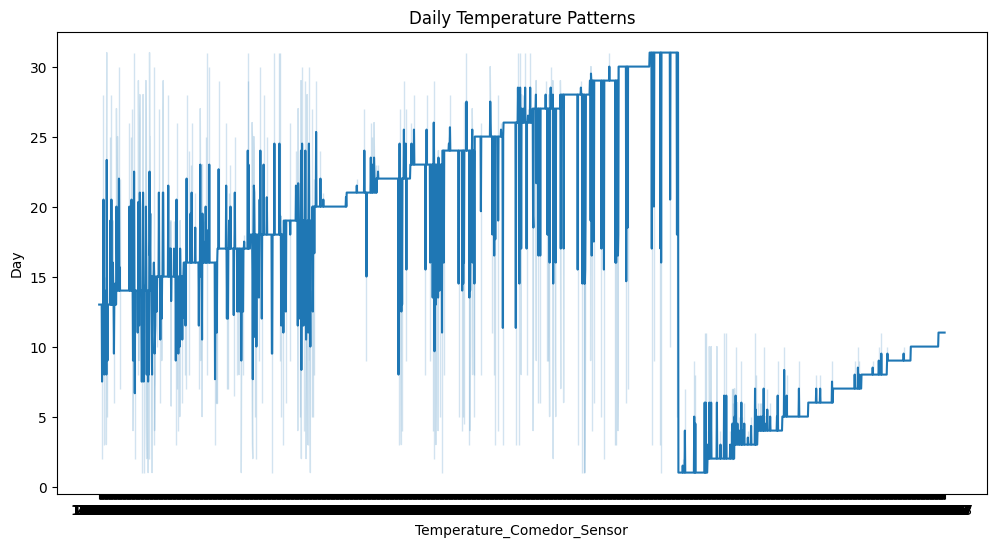

In [59]:
# Daily patterns
df['Day'] = df['Date'].dt.day
plt.figure(figsize=(12, 6))
sns.lineplot(x='Temperature_Comedor_Sensor', y='Day', data=df)
plt.title('Daily Temperature Patterns')
plt.show()

Time-Based Analysis (Hourly): 

In [60]:
# First convert numeric columns to float (if not already done)
numeric_cols = ['Temperature_Comedor_Sensor', 'Temperature_Habitacion_Sensor', 
                'CO2_Comedor_Sensor', 'Humedad_Comedor_Sensor']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # coerce will turn invalid values to NaN

# Now create interaction features
df['Temp_Ratio'] = df['Temperature_Comedor_Sensor'] / df['Temperature_Habitacion_Sensor']
df['CO2_Humidity'] = df['CO2_Comedor_Sensor'] * df['Humedad_Comedor_Sensor']

# Time-based features
df['Weekend'] = df['Day_Of_Week'].isin([5, 6]).astype(int)
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)  # 1=Winter, 2=Spring, etc.

# Check the new features
print(df[['Temp_Ratio', 'CO2_Humidity', 'Weekend', 'Season']].head())

   Temp_Ratio  CO2_Humidity  Weekend  Season
0    1.020194   8643.451000        0       2
1    1.018907   8781.757885        0       2
2    1.017932   8726.096116        0       2
3    1.017140   8695.550688        0       2
4    1.017367   8659.726750        0       2


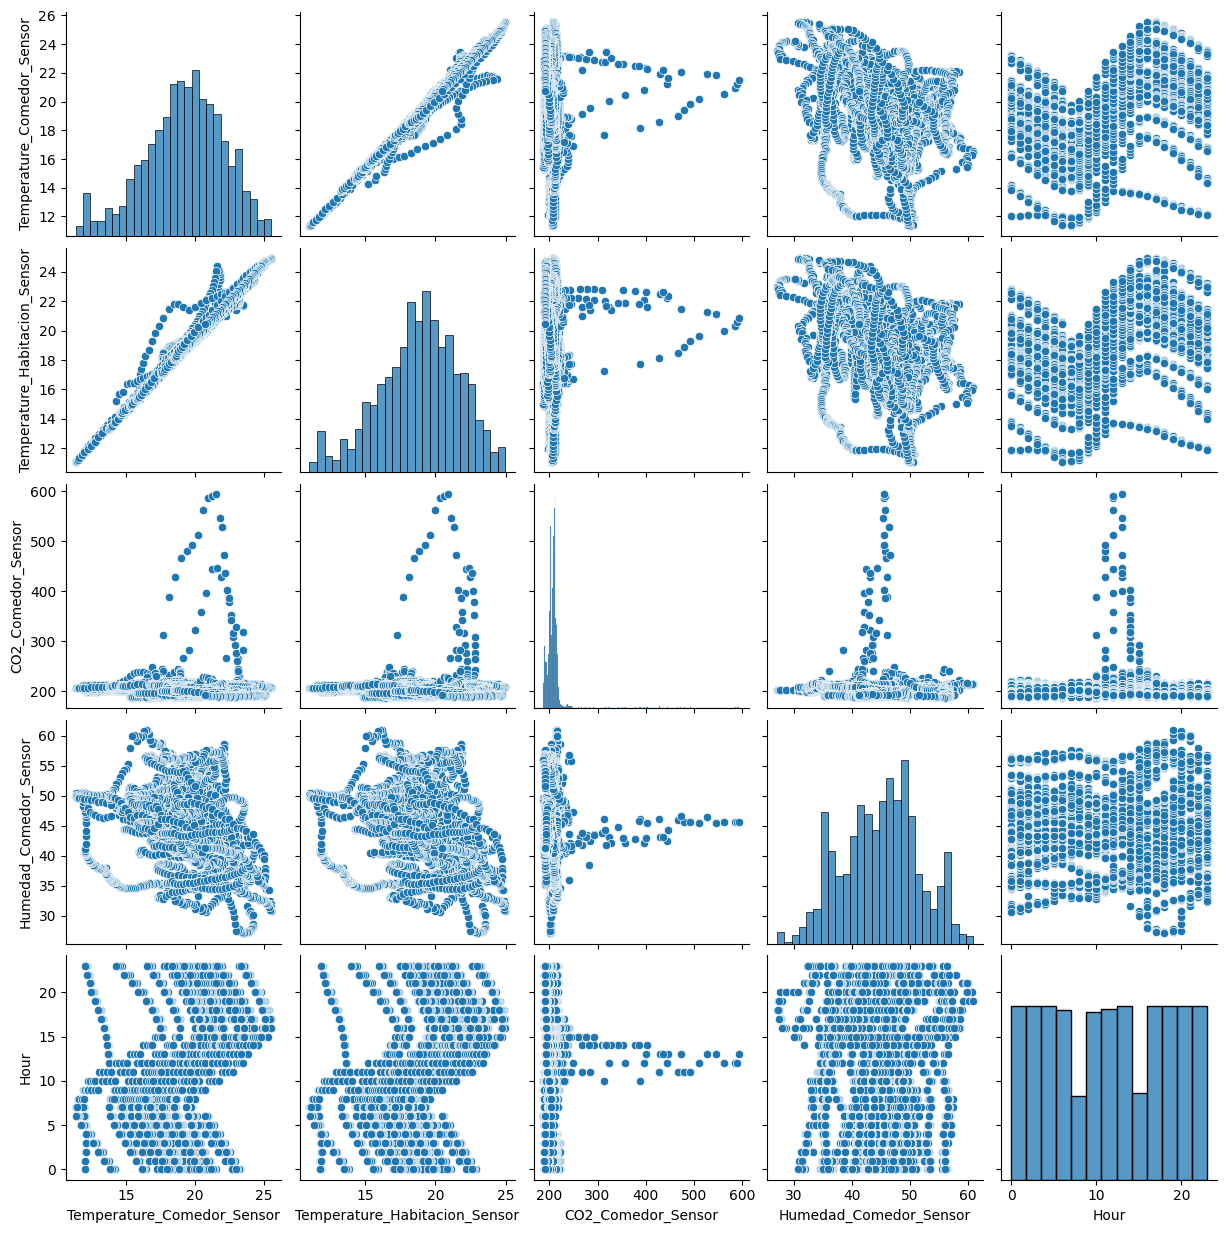

In [61]:
# Pairplot for feature relationships
sns.pairplot(df[['Temperature_Comedor_Sensor', 'Temperature_Habitacion_Sensor', 
                'CO2_Comedor_Sensor', 'Humedad_Comedor_Sensor', 'Hour']])
plt.show()


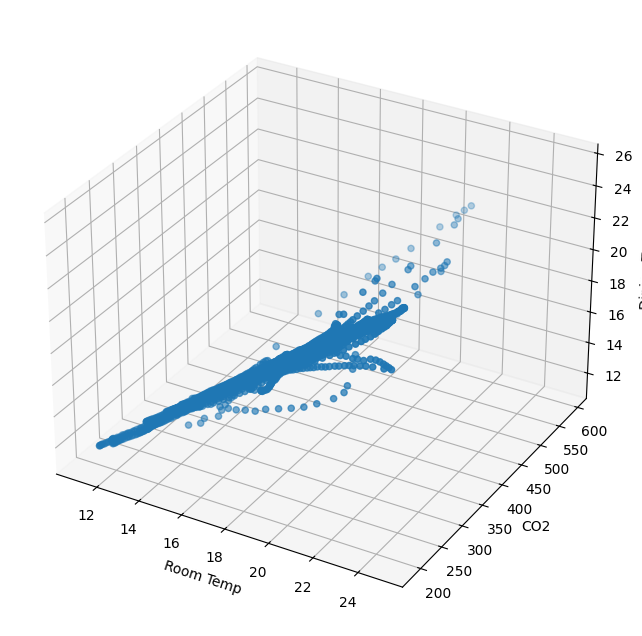

In [62]:
# 3D plot (requires matplotlib 3D axes)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Temperature_Habitacion_Sensor'], 
           df['CO2_Comedor_Sensor'], 
           df['Temperature_Comedor_Sensor'])
ax.set_xlabel('Room Temp')
ax.set_ylabel('CO2')
ax.set_zlabel('Dining Temp')
plt.show()

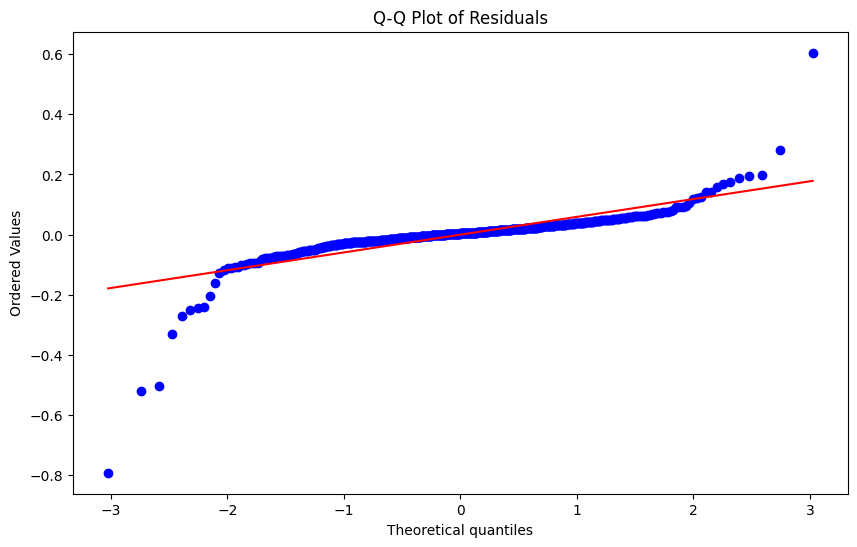

In [63]:
# Residual analysis
import scipy.stats as stats
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


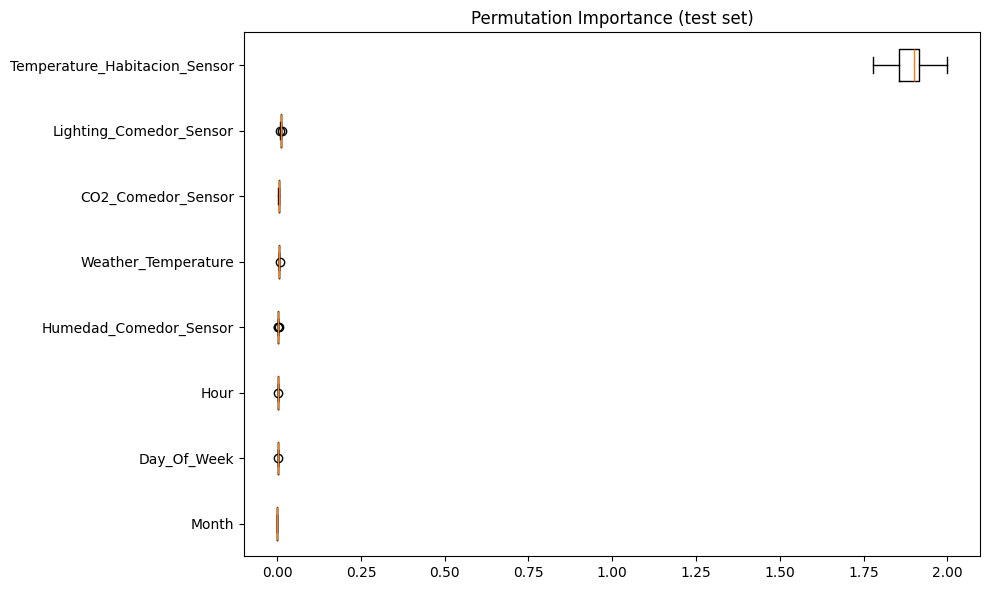

In [64]:
# Feature importance analysis (compatible with NumPy 2.2)
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# 1. Permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=np.array(feature_columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()


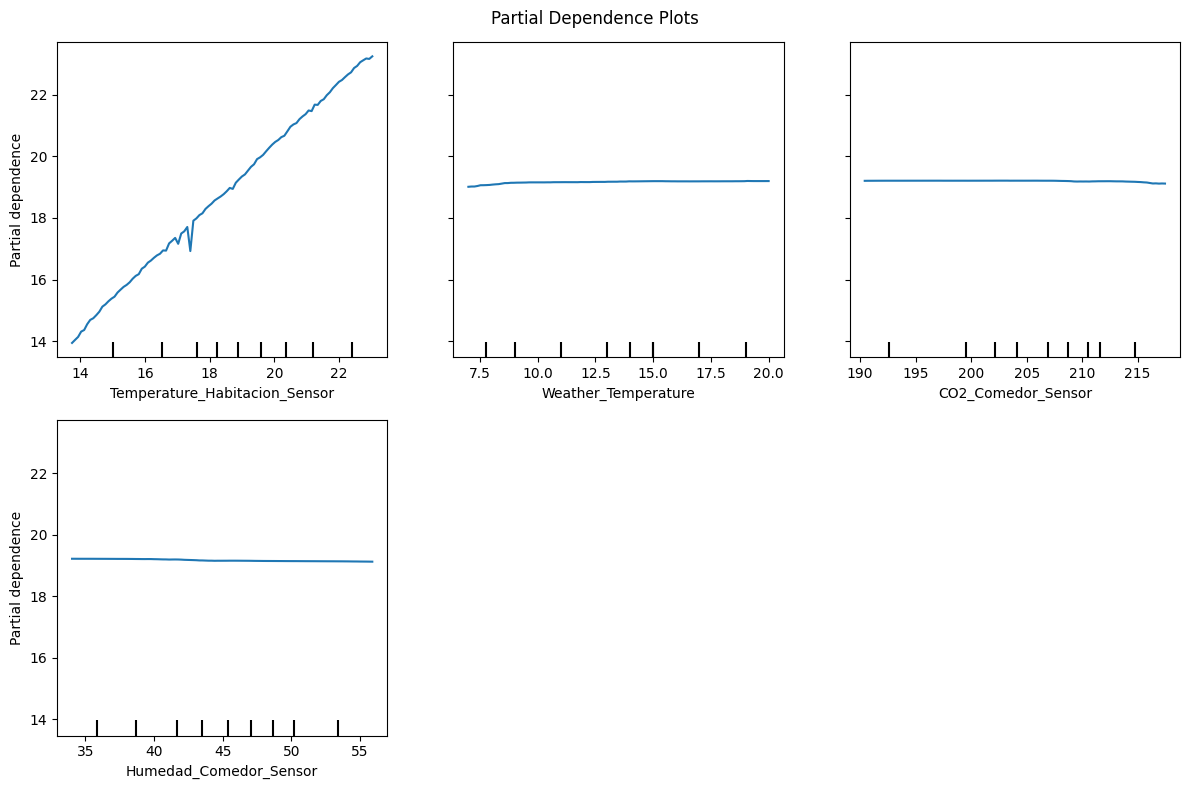

In [65]:
# 2. Partial Dependence Plots
fig, ax = plt.subplots(figsize=(12, 8))
# Convert data to float to avoid type errors
X_test_float = X_test.astype(float)
PartialDependenceDisplay.from_estimator(best_model, X_test_float, 
                                      features=[0, 1, 2, 3], 
                                      feature_names=feature_columns,
                                      ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
plt.show()

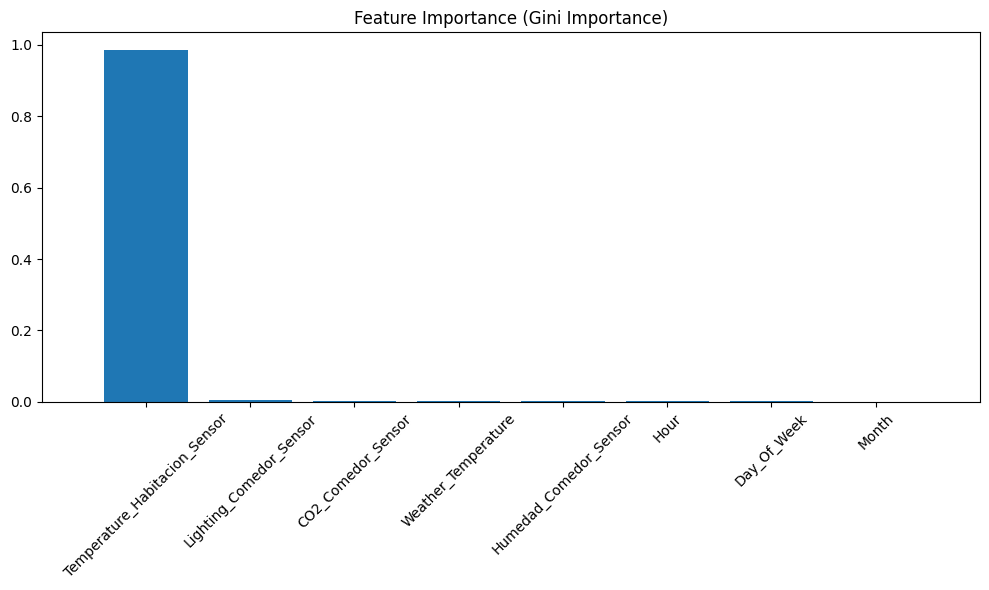

In [66]:

# 3. Feature Importance (built-in)
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance (Gini Importance)")
    plt.bar(range(X_test.shape[1]), importance[indices], align="center")
    plt.xticks(range(X_test.shape[1]), np.array(feature_columns)[indices], rotation=45)
    plt.xlim([-1, X_test.shape[1]])
    plt.tight_layout()
    plt.show()

In [67]:
# Environmental Analysis
print("\n=== Environmental Analysis ===")

# First, convert numeric columns to float
numeric_columns = [
    'Temperature_Comedor_Sensor', 'Temperature_Habitacion_Sensor',
    'Temperature_Exterior_Sensor', 'CO2_Comedor_Sensor',
    'CO2_Habitacion_Sensor', 'Humedad_Comedor_Sensor',
    'Humedad_Habitacion_Sensor', 'Humedad_Exterior_Sensor',
    'Lighting_Comedor_Sensor', 'Lighting_Habitacion_Sensor',
    'Weather_Temperature'
]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 1. Exterior vs Interior Temperature Analysis
df['Temp_Diff_Comedor'] = df['Temperature_Comedor_Sensor'] - df['Temperature_Exterior_Sensor']
df['Temp_Diff_Habitacion'] = df['Temperature_Habitacion_Sensor'] - df['Temperature_Exterior_Sensor']

# Calculate average temperature differences by hour
temp_diff_hourly = df.groupby('Hour').agg({
    'Temp_Diff_Comedor': 'mean',
    'Temp_Diff_Habitacion': 'mean',
    'Temperature_Exterior_Sensor': 'mean'
}).round(2)

print("\nAverage Temperature Differences by Hour:")
print(temp_diff_hourly)




=== Environmental Analysis ===

Average Temperature Differences by Hour:
      Temp_Diff_Comedor  Temp_Diff_Habitacion  Temperature_Exterior_Sensor
Hour                                                                      
0                  4.02                  3.59                        14.98
1                  4.09                  3.67                        14.52
2                  4.14                  3.73                        14.07
3                  4.16                  3.75                        13.67
4                  4.17                  3.76                        13.29
5                  4.15                  3.75                        12.94
6                  4.13                  3.73                        12.58
7                  3.71                  3.31                        12.68
8                  2.74                  2.40                        13.74
9                  1.66                  1.42                        15.29
10                 0.74   

In [68]:
# 2. CO2 and Occupancy Analysis
df['CO2_Diff'] = df['CO2_Comedor_Sensor'] - df['CO2_Habitacion_Sensor']
df['Avg_CO2'] = (df['CO2_Comedor_Sensor'] + df['CO2_Habitacion_Sensor']) / 2

# Calculate occupancy patterns
co2_hourly = df.groupby('Hour').agg({
    'CO2_Comedor_Sensor': 'mean',
    'CO2_Habitacion_Sensor': 'mean',
    'Avg_CO2': 'mean'
}).round(2)

print("\nCO2 Levels by Hour (indicating occupancy patterns):")
print(co2_hourly)




CO2 Levels by Hour (indicating occupancy patterns):
      CO2_Comedor_Sensor  CO2_Habitacion_Sensor  Avg_CO2
Hour                                                    
0                 205.99                 208.98   207.48
1                 205.68                 208.46   207.07
2                 205.06                 207.75   206.41
3                 204.32                 206.99   205.65
4                 203.98                 206.82   205.40
5                 203.94                 207.02   205.48
6                 204.83                 208.40   206.61
7                 206.05                 209.34   207.69
8                 206.49                 208.35   207.42
9                 206.79                 208.01   207.40
10                209.58                 211.57   210.57
11                217.72                 221.83   219.77
12                226.41                 232.50   229.46
13                226.99                 227.51   227.25
14                219.58           

In [69]:
# 3. Humidity Analysis
df['Humidity_Diff_Comedor'] = df['Humedad_Comedor_Sensor'] - df['Humedad_Exterior_Sensor']
df['Humidity_Diff_Habitacion'] = df['Humedad_Habitacion_Sensor'] - df['Humedad_Exterior_Sensor']

# Calculate humidity patterns
humidity_hourly = df.groupby('Hour').agg({
    'Humidity_Diff_Comedor': 'mean',
    'Humidity_Diff_Habitacion': 'mean',
    'Humedad_Exterior_Sensor': 'mean'
}).round(2)

print("\nHumidity Differences by Hour:")
print(humidity_hourly)



Humidity Differences by Hour:
      Humidity_Diff_Comedor  Humidity_Diff_Habitacion  Humedad_Exterior_Sensor
Hour                                                                          
0                    -13.85                    -10.80                    58.76
1                    -14.32                    -11.20                    59.08
2                    -14.87                    -11.63                    59.64
3                    -15.32                    -12.03                    60.20
4                    -15.71                    -12.46                    60.67
5                    -16.09                    -12.90                    61.16
6                    -16.48                    -13.28                    61.68
7                    -15.65                    -12.51                    60.97
8                    -13.80                    -11.29                    59.13
9                    -12.67                    -10.76                    57.74
10                   

In [70]:
# 4. Lighting and Temperature Correlation
lighting_temp_corr = df.groupby('Hour').agg({
    'Lighting_Comedor_Sensor': 'mean',
    'Temperature_Comedor_Sensor': 'mean',
    'Lighting_Habitacion_Sensor': 'mean',
    'Temperature_Habitacion_Sensor': 'mean'
}).round(2)

print("\nLighting and Temperature Correlation by Hour:")
print(lighting_temp_corr)



Lighting and Temperature Correlation by Hour:
      Lighting_Comedor_Sensor  Temperature_Comedor_Sensor  \
Hour                                                        
0                       11.56                       19.01   
1                       11.60                       18.61   
2                       11.60                       18.22   
3                       11.62                       17.83   
4                       11.62                       17.45   
5                       11.63                       17.09   
6                       16.44                       16.71   
7                       20.75                       16.39   
8                       28.63                       16.49   
9                       43.04                       16.95   
10                      62.39                       17.74   
11                      73.64                       18.73   
12                      73.26                       19.70   
13                      66.38         

Weather Impact: 

In [71]:
# 5. Weather Impact Analysis
weather_impact = df.groupby('Weather_Temperature').agg({
    'Temperature_Comedor_Sensor': 'mean',
    'Temperature_Habitacion_Sensor': 'mean',
    'Humedad_Comedor_Sensor': 'mean',
    'Humedad_Habitacion_Sensor': 'mean'
}).round(2)

print("\nWeather Impact on Interior Conditions:")
print(weather_impact)


Weather Impact on Interior Conditions:
                     Temperature_Comedor_Sensor  \
Weather_Temperature                               
0.00000                                   18.19   
4.00000                                   17.77   
4.86667                                   17.88   
5.00000                                   13.79   
5.33333                                   11.35   
...                                         ...   
25.53330                                  23.09   
25.73330                                  23.30   
25.80000                                  22.49   
25.86670                                  25.13   
26.00000                                  24.07   

                     Temperature_Habitacion_Sensor  Humedad_Comedor_Sensor  \
Weather_Temperature                                                          
0.00000                                      17.83                   39.91   
4.00000                                      18.55            